# RAVDESS PyCaret Quickstart
Simple starter notebook for running PyCaret AutoML on the ABT feature table.

## 1. Load Data
Checks the file path and loads the Analytics Base Table (ABT) into a pandas DataFrame.

In [1]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import pandas as pd

DATA_PATH = Path('../data/processed/ravdess_mfcc_features.csv')
print(f'Data path: {DATA_PATH.resolve()}')
if not DATA_PATH.exists():
    raise FileNotFoundError('Expected ravdess_mfcc_features.csv under ../data/processed. Run the MFCC feature notebook first.')

df = pd.read_csv(DATA_PATH)
print(f'Shape: {df.shape[0]:,} rows × {df.shape[1]:,} columns')
df.head()


Data path: E:\My Drive\UA&P\UA&P Classes\Data Science\Projects\RAVDESS\data\processed\ravdess_mfcc_features.csv
Shape: 1,440 rows × 82 columns


,file_path,emotion,mfcc1_mean,mfcc1_std,mfcc2_mean,mfcc2_std,mfcc3_mean,mfcc3_std,mfcc4_mean,mfcc4_std,...,delta_mfcc16_mean,delta_mfcc16_std,delta_mfcc17_mean,delta_mfcc17_std,delta_mfcc18_mean,delta_mfcc18_std,delta_mfcc19_mean,delta_mfcc19_std,delta_mfcc20_mean,delta_mfcc20_std
0,/home/nico/ds_workspace/projects/RAVDESS/data/...,neutral,-697.792603,183.030441,54.890038,72.168480,0.663467,19.195799,12.435785,20.930756,...,-0.002792,0.586559,-0.002690,1.398391,-0.002583,0.924114,-0.002471,1.030372,-0.002355,0.532815
1,/home/nico/ds_workspace/projects/RAVDESS/data/...,neutral,-692.855774,185.050293,55.363899,66.308495,-1.548319,19.290407,16.038307,19.345299,...,0.002108,0.810777,0.001907,1.409166,0.001725,0.780301,0.001558,1.106086,0.001402,0.734610
2,/home/nico/ds_workspace/projects/RAVDESS/data/...,neutral,-691.587891,190.336121,58.024662,72.184830,0.159465,21.651524,13.624649,19.525526,...,0.002610,0.961857,0.003390,1.230899,0.003745,0.934672,0.003710,1.016712,0.003397,0.742823
3,/home/nico/ds_workspace/projects/RAVDESS/data/...,neutral,-685.105469,184.565063,55.879421,66.488159,2.783262,20.100769,13.252023,20.778818,...,-0.008956,0.902226,0.011267,1.463178,-0.005738,0.781945,-0.017210,1.092176,0.006392,1.017392
4,/home/nico/ds_workspace/projects/RAVDESS/data/...,calm,-727.104370,182.821884,62.355034,68.404228,3.121181,22.141096,15.064669,20.880312,...,-0.011788,0.991112,-0.009131,1.817581,-0.007516,0.953957,-0.006220,0.920864,-0.004666,1.083396


In [2]:
feature_cols = [c for c in df.columns if c.startswith(('mfcc', 'delta_mfcc'))]
if 'emotion' not in df.columns:
    raise KeyError("Expected target column 'emotion' in MFCC feature table")
df_prepped = df[feature_cols + ['emotion']].copy()
print(f'Prepared dataframe with {len(feature_cols)} feature columns + emotion target')
df_prepped.head()

Prepared dataframe with 80 feature columns + emotion target


,mfcc1_mean,mfcc1_std,mfcc2_mean,mfcc2_std,mfcc3_mean,mfcc3_std,mfcc4_mean,mfcc4_std,mfcc5_mean,mfcc5_std,...,delta_mfcc16_std,delta_mfcc17_mean,delta_mfcc17_std,delta_mfcc18_mean,delta_mfcc18_std,delta_mfcc19_mean,delta_mfcc19_std,delta_mfcc20_mean,delta_mfcc20_std,emotion
0,-697.792603,183.030441,54.890038,72.168480,0.663467,19.195799,12.435785,20.930756,7.733952,17.339310,...,0.586559,-0.002690,1.398391,-0.002583,0.924114,-0.002471,1.030372,-0.002355,0.532815,neutral
1,-692.855774,185.050293,55.363899,66.308495,-1.548319,19.290407,16.038307,19.345299,8.818810,17.269623,...,0.810777,0.001907,1.409166,0.001725,0.780301,0.001558,1.106086,0.001402,0.734610,neutral
2,-691.587891,190.336121,58.024662,72.184830,0.159465,21.651524,13.624649,19.525526,5.374113,16.699015,...,0.961857,0.003390,1.230899,0.003745,0.934672,0.003710,1.016712,0.003397,0.742823,neutral
3,-685.105469,184.565063,55.879421,66.488159,2.783262,20.100769,13.252023,20.778818,6.989669,16.527094,...,0.902226,0.011267,1.463178,-0.005738,0.781945,-0.017210,1.092176,0.006392,1.017392,neutral
4,-727.104370,182.821884,62.355034,68.404228,3.121181,22.141096,15.064669,20.880312,8.132435,18.506636,...,0.991112,-0.009131,1.817581,-0.007516,0.953957,-0.006220,0.920864,-0.004666,1.083396,calm


In [3]:
# Chance-level baselines for reference
class_counts = df_prepped['emotion'].value_counts()
random_guess_accuracy = 1.0 / class_counts.size
majority_class = class_counts.idxmax()
majority_accuracy = class_counts.max() / class_counts.sum()
print(f'Random-guess baseline (1/num_classes): {random_guess_accuracy:.3f}')
print(f'Majority-class baseline ({majority_class}): {majority_accuracy:.3f}')
class_counts


Random-guess baseline (1/num_classes): 0.125
Majority-class baseline (calm): 0.133


emotion
calm         192
happy        192
sad          192
angry        192
fearful      192
disgust      192
surprised    192
neutral       96
Name: count, dtype: int64

In [4]:
# Proportional chance criterion (sum of squared class probs)
class_probs = (class_counts / class_counts.sum()).sort_index()
pcc = float((class_probs ** 2).sum())
print('Class probabilities:')
display(class_probs)
print(f'Proportional chance criterion (PCC): {pcc:.3f}')


Class probabilities:


emotion
angry        0.133333
calm         0.133333
disgust      0.133333
fearful      0.133333
happy        0.133333
neutral      0.066667
sad          0.133333
surprised    0.133333
Name: count, dtype: float64

Proportional chance criterion (PCC): 0.129


## 2. PyCaret Setup
Initializes PyCaret's classification module using the full ABT dataframe.

In [5]:
from pycaret.classification import *

pycaret_setup = setup(
    data=df_prepped,
    target='emotion',
    session_id=42,
    fold=5,
    train_size=0.7,
    normalize=True,
    transformation=False,
    fix_imbalance=False,
    feature_selection=False,
    remove_multicollinearity=False,
    low_variance_threshold=None,
    use_gpu=False,
    verbose=True
)


,Description,Value
0,Session id,42
1,Target,emotion
2,Target type,Multiclass
3,Target mapping,"angry: 0, calm: 1, disgust: 2, fearful: 3, happy: 4, neutral: 5, sad: 6, surprised: 7"
4,Original data shape,"(1440, 81)"
5,Transformed data shape,"(1440, 81)"
6,Transformed train set shape,"(1007, 81)"
7,Transformed test set shape,"(433, 81)"
8,Numeric features,80
9,Preprocess,True


## 3. Compare Models
Run PyCaret's `compare_models` to get a quick leaderboard and keep the top performers.

In [6]:
top_models = compare_models(n_select=3, sort='Accuracy', turbo=True)
compare_results = pull()
compare_results


,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,16:29:44
Status,. . . . . . . . . . . . . . . . . .,Loading Dependencies
Estimator,. . . . . . . . . . . . . . . . . .,Compiling Library


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.6207,0.9078,0.6207,0.6259,0.6163,0.5643,0.5661,1.5880
et,Extra Trees Classifier,0.6137,0.8997,0.6137,0.6268,0.6046,0.5554,0.5594,0.0740
rf,Random Forest Classifier,0.5700,0.8789,0.5700,0.5790,0.5587,0.5051,0.5085,0.1440
lda,Linear Discriminant Analysis,0.5661,0.0000,0.5661,0.5710,0.5631,0.5018,0.5032,0.0220
lr,Logistic Regression,0.5641,0.0000,0.5641,0.5677,0.5603,0.4995,0.5009,0.9540
ridge,Ridge Classifier,0.5641,0.0000,0.5641,0.5610,0.5485,0.4978,0.5010,0.0220
gbc,Gradient Boosting Classifier,0.5571,0.0000,0.5571,0.5640,0.5537,0.4906,0.4925,3.6400
svm,SVM - Linear Kernel,0.5482,0.0000,0.5482,0.5541,0.5454,0.4806,0.4820,0.0320
knn,K Neighbors Classifier,0.4707,0.8173,0.4707,0.4784,0.4601,0.3918,0.3960,0.7620
qda,Quadratic Discriminant Analysis,0.4638,0.0000,0.4638,0.4683,0.4504,0.3813,0.3880,0.0220


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.6207,0.9078,0.6207,0.6259,0.6163,0.5643,0.5661,1.588
et,Extra Trees Classifier,0.6137,0.8997,0.6137,0.6268,0.6046,0.5554,0.5594,0.074
rf,Random Forest Classifier,0.5700,0.8789,0.5700,0.5790,0.5587,0.5051,0.5085,0.144
lda,Linear Discriminant Analysis,0.5661,0.0000,0.5661,0.5710,0.5631,0.5018,0.5032,0.022
lr,Logistic Regression,0.5641,0.0000,0.5641,0.5677,0.5603,0.4995,0.5009,0.954
ridge,Ridge Classifier,0.5641,0.0000,0.5641,0.5610,0.5485,0.4978,0.5010,0.022
gbc,Gradient Boosting Classifier,0.5571,0.0000,0.5571,0.5640,0.5537,0.4906,0.4925,3.640
svm,SVM - Linear Kernel,0.5482,0.0000,0.5482,0.5541,0.5454,0.4806,0.4820,0.032
knn,K Neighbors Classifier,0.4707,0.8173,0.4707,0.4784,0.4601,0.3918,0.3960,0.762
qda,Quadratic Discriminant Analysis,0.4638,0.0000,0.4638,0.4683,0.4504,0.3813,0.3880,0.022


In [7]:
# Save the leaderboard to CSV
OUTPUT_DIR = Path('../output/pycaret_exports')
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
leaderboard_path = OUTPUT_DIR / 'pycaret_mfcc_leaderboard_full.csv'
compare_results.to_csv(leaderboard_path, index=False)
print('Saved leaderboard to', leaderboard_path)

Saved leaderboard to ..\output\pycaret_exports\pycaret_mfcc_leaderboard_full.csv


## You may reload the leaderboard

In [8]:
import pandas as pd
leaderboard = pd.read_csv(leaderboard_path)
leaderboard.head()


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
0,Light Gradient Boosting Machine,0.6207,0.9078,0.6207,0.6259,0.6163,0.5643,0.5661,1.588
1,Extra Trees Classifier,0.6137,0.8997,0.6137,0.6268,0.6046,0.5554,0.5594,0.074
2,Random Forest Classifier,0.5700,0.8789,0.5700,0.5790,0.5587,0.5051,0.5085,0.144
3,Linear Discriminant Analysis,0.5661,0.0000,0.5661,0.5710,0.5631,0.5018,0.5032,0.022
4,Logistic Regression,0.5641,0.0000,0.5641,0.5677,0.5603,0.4995,0.5009,0.954


## 4. Tune / Finalize
Select the leading model, optionally tune, and prepare it for downstream predictions.

In [9]:
best_model = top_models[0] if isinstance(top_models, list) else top_models
tuned_model = tune_model(best_model, optimize='Accuracy', fold=5)
evaluate_model(tuned_model)
final_model = finalize_model(tuned_model)
final_model


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.5743,0.8849,0.5743,0.5694,0.5667,0.5110,0.5124
1,0.5644,0.8904,0.5644,0.5589,0.5476,0.4983,0.5017
2,0.5771,0.9009,0.5771,0.5961,0.5825,0.5145,0.5159
3,0.5771,0.8988,0.5771,0.5904,0.5789,0.5139,0.5155
4,0.5572,0.8906,0.5572,0.5620,0.5564,0.4915,0.4924
Mean,0.5700,0.8931,0.5700,0.5754,0.5664,0.5059,0.5076
Std,0.0079,0.0059,0.0079,0.0151,0.0132,0.0093,0.0092


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

Pipeline(memory=Memory(location=None),
         steps=[('label_encoding',
                 TransformerWrapperWithInverse(exclude=None, include=None,
                                               transformer=LabelEncoder())),
                ('numerical_imputer',
                 TransformerWrapper(exclude=None,
                                    include=['mfcc1_mean', 'mfcc1_std',
                                             'mfcc2_mean', 'mfcc2_std',
                                             'mfcc3_mean', 'mfcc3_std',
                                             'mfcc4_mean', 'mfcc4_std',
                                             'mfcc5_mean', 'mfcc5_std',
                                             'mfcc6_mean', 'm...
                 LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                colsample_bytree=1.0, importance_type='split',
                                learning_rate=0.1, max_depth=-1,
                                min_child_samples=20, min_child_weight=0.001,
                                min_split_gain=0.0, n_estimators=100, n_jobs=-1,
                                num_leaves=31, objective=None, random_state=42,
                                reg_alpha=0.0, reg_lambda=0.0, subsample=1.0,
                                subsample_for_bin=200000, subsample_freq=0))],
         verbose=False)

Saved ROC plot to ..\output\pycaret_exports\pycaret_mfcc_macro_roc.png


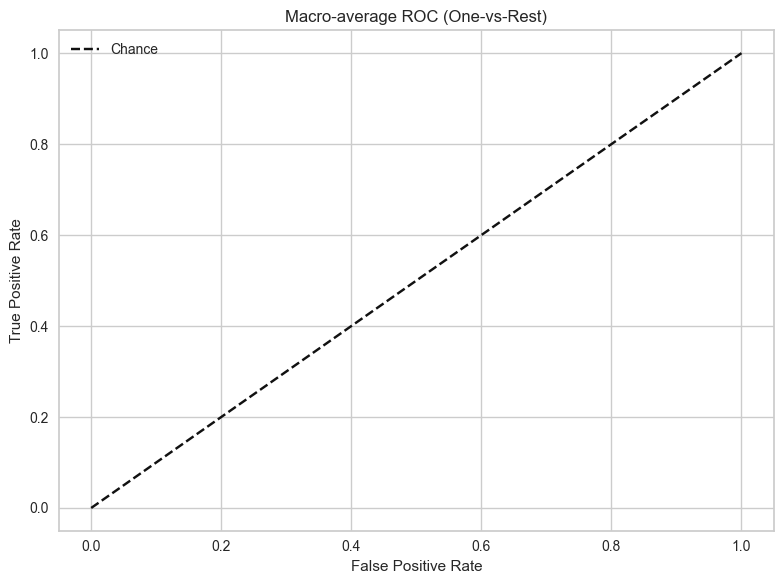

In [10]:
roc_models = top_models if isinstance(top_models, list) else [top_models]
for extra_model in [tuned_model, final_model]:
    if extra_model not in roc_models:
        roc_models.append(extra_model)

X_test = get_config('X_test').copy()
y_test = get_config('y_test').copy()
class_labels = sorted(df_prepped['emotion'].unique())
y_true = label_binarize(y_test, classes=class_labels)

plt.figure(figsize=(8, 6))
for model in roc_models:
    preds = predict_model(model, data=X_test, raw_score=True)
    score_cols = [f'Score_{label}' for label in class_labels]
    if not all(col in preds.columns for col in score_cols):
        continue
    y_score = preds[score_cols].values
    all_fpr = np.unique(np.concatenate([roc_curve(y_true[:, i], y_score[:, i])[0] for i in range(len(class_labels))]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(len(class_labels)):
        fpr, tpr, _ = roc_curve(y_true[:, i], y_score[:, i])
        mean_tpr += np.interp(all_fpr, fpr, tpr)
    mean_tpr /= len(class_labels)
    roc_auc = auc(all_fpr, mean_tpr)
    label_text = f"{model.__class__.__name__} (AUC={roc_auc:.2f})"
    plt.plot(all_fpr, mean_tpr, label=label_text)

plt.plot([0, 1], [0, 1], 'k--', label='Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Macro-average ROC (One-vs-Rest)')
plt.legend()
plt.grid(True)
plt.tight_layout()
roc_plot_path = OUTPUT_DIR / 'pycaret_mfcc_macro_roc.png'
plt.savefig(roc_plot_path, dpi=300, bbox_inches='tight')
print('Saved ROC plot to', roc_plot_path)


## 5. Predict Holdout
Use the finalized model to score PyCaret's holdout split for a quick sanity check.

In [11]:
holdout_predictions = predict_model(final_model)
holdout_predictions.head()


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000


,mfcc1_mean,mfcc1_std,mfcc2_mean,mfcc2_std,mfcc3_mean,mfcc3_std,mfcc4_mean,mfcc4_std,mfcc5_mean,mfcc5_std,...,delta_mfcc17_std,delta_mfcc18_mean,delta_mfcc18_std,delta_mfcc19_mean,delta_mfcc19_std,delta_mfcc20_mean,delta_mfcc20_std,emotion,prediction_label,prediction_score
1346,-652.416260,183.012802,43.324806,67.211273,4.350433,26.139227,3.992514,23.650070,5.259886,15.762671,...,1.540244,-3.532901e-04,1.051851,-3.523476e-04,0.864128,-3.513519e-04,1.044453,sad,sad,0.9995
1135,-744.686340,186.905457,67.081535,62.310589,18.314056,16.088591,21.004873,19.084621,5.289451,19.731571,...,1.102312,-3.292256e-04,1.036870,2.588139e-03,0.961698,1.423880e-02,0.756813,surprised,surprised,0.9996
1399,-505.676636,183.080292,19.306387,40.931213,-21.616112,35.342255,-4.345457,23.124298,-14.986020,21.362957,...,2.257955,2.284250e-08,2.971145,2.284250e-08,2.565660,2.284250e-08,2.297370,happy,happy,0.9993
888,-535.911499,165.539795,57.502937,60.133820,-9.185279,24.695467,13.241406,23.761032,10.439775,16.099436,...,1.250624,-2.073854e-04,1.142888,-4.952550e-05,1.001710,-1.311630e-04,0.987213,disgust,disgust,0.9998
86,-662.659729,173.522171,43.958710,58.937141,-6.310632,33.040318,4.213040,20.097345,-6.307642,16.896271,...,1.323239,-4.551011e-03,0.927738,-3.665400e-03,0.931669,-2.410461e-03,1.275219,sad,sad,0.9994


## Save the splits for future comparisons

In [12]:
from pycaret.classification import get_config
from pathlib import Path
import pandas as pd

# Get the split that PyCaret actually used
X_train = get_config("X_train")
X_test = get_config("X_test")
y_train = get_config("y_train")
y_test = get_config("y_test")

train_df = X_train.copy()
train_df["emotion"] = y_train

test_df = X_test.copy()
test_df["emotion"] = y_test

OUT_DIR = Path("../data/processed")
OUT_DIR.mkdir(parents=True, exist_ok=True)

train_path = OUT_DIR / "ravdess_mfcc_train_for_dl.csv"
test_path = OUT_DIR / "ravdess_mfcc_test_for_dl.csv"

train_df.to_csv(train_path, index=False)
test_df.to_csv(test_path, index=False)

print("Saved:")
print(" -", train_path)
print(" -", test_path)


Saved:
 - ..\data\processed\ravdess_mfcc_train_for_dl.csv
 - ..\data\processed\ravdess_mfcc_test_for_dl.csv


In [13]:
from pycaret.classification import save_model
from pathlib import Path
MODEL_OUTPUT = Path('../models/ravdess_mfcc_pycaret_lightgbm')
MODEL_OUTPUT.parent.mkdir(parents=True, exist_ok=True)
save_model(final_model, str(MODEL_OUTPUT))


Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('label_encoding',
                  TransformerWrapperWithInverse(exclude=None, include=None,
                                                transformer=LabelEncoder())),
                 ('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['mfcc1_mean', 'mfcc1_std',
                                              'mfcc2_mean', 'mfcc2_std',
                                              'mfcc3_mean', 'mfcc3_std',
                                              'mfcc4_mean', 'mfcc4_std',
                                              'mfcc5_mean', 'mfcc5_std',
                                              'mfcc6_mean', 'm...
                  LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                 colsample_bytree=1.0, importance_type='split',
                                 learning_rate=0.1, max_depth=-1,
                             

In [14]:
from pycaret.utils.generic import save_config
from pathlib import Path
CONFIG_PATH = Path('../models/ravdess_mfcc_pycaret_setup.pkl')
CONFIG_PATH.parent.mkdir(parents=True, exist_ok=True)
save_config(globals(), str(CONFIG_PATH))
print('Saved PyCaret setup to', CONFIG_PATH)


AttributeError: 'str' object has no attribute 'items'